## Import libraries 

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import re
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import statsmodels.api as sm

In [2]:
## Read raw csv file 

In [3]:
df = pd.read_csv("Earnings and Hours Worked in the Building and Construction Industry.csv", skiprows=[1])

In [4]:
df.head() ## check the first five rows of dataframe

,Unnamed: 0,All manual employee grades,Skilled operatives,Apprentices,Unskilled and semi-skilled - adults,Unskilled and semi-skilled - juveniles,Clerical employees - female,Clerical employees - male,Foremen and supervisors,All employees (clerical and operatives)
0,1969Q1,NaN,"5,024",NaN,"7,009",NaN,NaN,NaN,NaN,NaN
1,1969Q2,NaN,"5,338",NaN,"7,659",NaN,NaN,NaN,NaN,NaN
2,1969Q3,"14,893","4,753","1,279","7,545",326.0,443,564.0,990,"15,900"
3,1969Q4,NaN,"3,964",NaN,"5,906",NaN,NaN,NaN,NaN,NaN
4,1970Q1,NaN,"6,029",NaN,"8,371",NaN,NaN,NaN,NaN,NaN


In [5]:
df.shape ##  check the number of rows and columns in dataframe

(160, 10)

In [6]:
## Convert column Unnamed: 0 to a new column date and convert into datetime format
df['date'] = (
    pd.to_datetime(
        df['Unnamed: 0'].str.split(' ').apply(lambda x: ''.join(x[::-1]))
))
df.drop(["Unnamed: 0"],axis=1,inplace=True)

In [17]:
df.info() ## to verifying Datatype and number of null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Manual_employee_grades     160 non-null    object        
 1   Skilled_operatives         160 non-null    object        
 2   Apprentices                160 non-null    object        
 3   Semi_skilled_adults        160 non-null    object        
 4   Semi_skilled_juveniles     160 non-null    float64       
 5   Clerical_employees_female  160 non-null    object        
 6   Clerical_employees_male    160 non-null    float64       
 7   Foremen_and_supervisors    160 non-null    object        
 8   Clerical_and_Operatives    160 non-null    object        
 9   date                       160 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 12.6+ KB


In [18]:
## rename the columns for python friendly
df=df.rename(columns={'All manual employee grades':'Manual_employee_grades',
            'Skilled operatives':'Skilled_operatives','Unskilled and semi-skilled - adults':'Semi_skilled_adults',
            'Unskilled and semi-skilled - juveniles':'Semi_skilled_juveniles',
            'Clerical employees - female':'Clerical_employees_female',
            'Clerical employees - male':'Clerical_employees_male',
            'Foremen and supervisors':'Foremen_and_supervisors',
            'All employees (clerical and operatives)':'Clerical_and_Operatives'})

In [19]:
## remove ',' from each column
df['Manual_employee_grades']=df['Manual_employee_grades'].str.replace(',','') 
df['Skilled_operatives']=df['Skilled_operatives'].str.replace(',','')
df['Apprentices']=df['Apprentices'].str.replace(',','')
df['Semi_skilled_adults']=df['Semi_skilled_adults'].str.replace(',','')
df['Clerical_and_Operatives']=df['Clerical_and_Operatives'].str.replace(',','')
df['Clerical_employees_female']=df['Clerical_employees_female'].str.replace(',','')
df['Foremen_and_supervisors']=df['Foremen_and_supervisors'].str.replace(',','')

In [20]:
df.isnull().sum() ## verify any missing values in dataframe

Manual_employee_grades       0
Skilled_operatives           0
Apprentices                  0
Semi_skilled_adults          0
Semi_skilled_juveniles       0
Clerical_employees_female    0
Clerical_employees_male      0
Foremen_and_supervisors      0
Clerical_and_Operatives      0
date                         0
dtype: int64

In [21]:
df = df.fillna(method='ffill') ## filling the missing values with forward fill method as less number of labels are missing

In [22]:
df = df.fillna(method='backfill') ## after forward fill only 2 labels missing, so I am using back fill method.

In [23]:
## to do forther analysis we need to convert data type to int for all the variables
df= df.astype({'Manual_employee_grades':'int','Skilled_operatives':'int','Apprentices':'int','Semi_skilled_juveniles':'int',
              'Semi_skilled_adults':'int','Clerical_employees_female':'int','Clerical_employees_male':'int','Clerical_and_Operatives':'int'})

In [24]:
df["Foremen_and_supervisors"]=df["Foremen_and_supervisors"].astype('float64') ## convert object to float 

In [25]:
df["Foremen_and_supervisors"]=df["Foremen_and_supervisors"].astype('int') ## convert from float to int

In [26]:
df.info() ## verify all the variables are now in int datatype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Manual_employee_grades     160 non-null    int32         
 1   Skilled_operatives         160 non-null    int32         
 2   Apprentices                160 non-null    int32         
 3   Semi_skilled_adults        160 non-null    int32         
 4   Semi_skilled_juveniles     160 non-null    int32         
 5   Clerical_employees_female  160 non-null    int32         
 6   Clerical_employees_male    160 non-null    int32         
 7   Foremen_and_supervisors    160 non-null    int32         
 8   Clerical_and_Operatives    160 non-null    int32         
 9   date                       160 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int32(9)
memory usage: 7.0 KB


## Time Series Analysis from here

In [27]:
## df_tsa=df.to_csv('df_tsa.csv', index=False) ## to use date as index column for time series we read cleaned dataframe to csv 

In [28]:
df=pd.read_csv("df_tsa.csv",index_col='date',parse_dates=True) ## reading cleaned csv file and keeping date column as index.

In [29]:
df.shape ## number of rows and columns

(160, 9)

In [30]:
df.head() ## top 5 rows of data

,Manual_employee_grades,Skilled_operatives,Apprentices,Semi_skilled_adults,Semi_skilled_juveniles,Clerical_employees_female,Clerical_employees_male,Foremen_and_supervisors,Clerical_and_Operatives
date,,,,,,,,,
1969-01-01,14893,5024,1279,7009,326,443,564,990,15900
1969-04-01,14893,5338,1279,7659,326,443,564,990,15900
1969-07-01,14893,4753,1279,7545,326,443,564,990,15900
1969-10-01,14893,3964,1279,5906,326,443,564,990,15900
1970-01-01,14893,6029,1279,8371,326,443,564,990,15900


In [31]:
## for time series I am only interested in one column 'Clerical_employees_female' to forcast the female earnings.
columns_of_interest = ['Clerical_employees_female']
df = df[columns_of_interest]

In [32]:
df.head() ## verify first 5 rows

,Clerical_employees_female
date,
1969-01-01,443
1969-04-01,443
1969-07-01,443
1969-10-01,443
1970-01-01,443


In [33]:
df.tail() # verifiy last 5 rows

,Clerical_employees_female
date,
2007-10-01,1119
2008-01-01,1126
2008-04-01,1148
2008-07-01,1029
2008-10-01,951


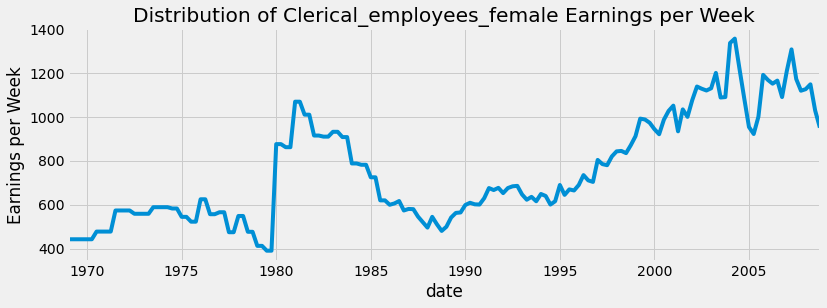

In [34]:
df['Clerical_employees_female'].plot(figsize=(12,4))
plt.ylabel('Earnings per Week')
plt.title(f'Distribution of Clerical_employees_female Earnings per Week')
plt.show(); ## plot the Clerical_employees_female data to find the earnings trends

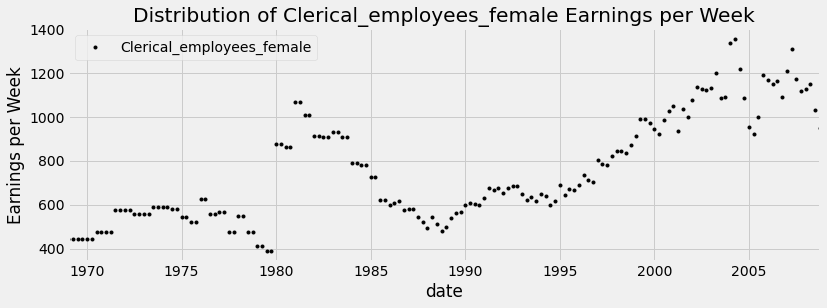

In [35]:
df.plot(figsize=(12,4), style = 'k.')
plt.ylabel('Earnings per Week')
plt.title(f'Distribution of Clerical_employees_female Earnings per Week')
plt.show(); # plot in '.' style

In [36]:
## smoothing the time series is done by the "moving avg(ma)"
df_ma = df.rolling(window=15).mean()

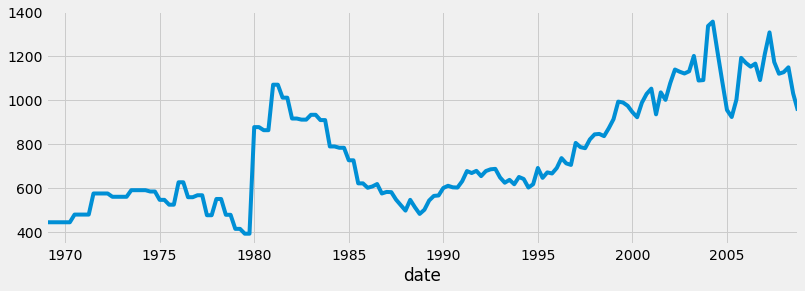

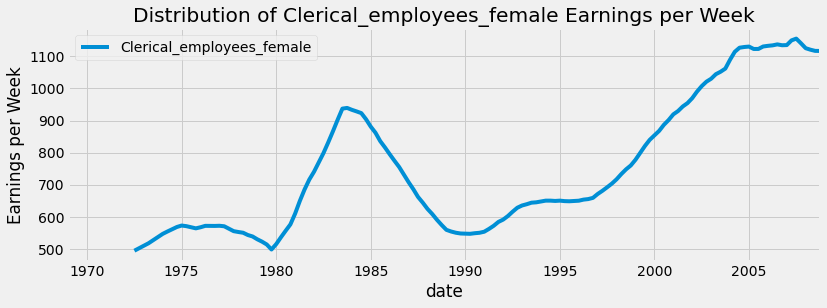

In [37]:
df['Clerical_employees_female'].plot(figsize=(12,4))
df_ma.plot(figsize=(12,4))
plt.ylabel('Earnings per Week')
plt.title(f'Distribution of Clerical_employees_female Earnings per Week')
plt.show();

In [38]:
# Method 1: Perform Augmented Dickey-Fuller test:
# ADF Test - nul hypothesis - non-stationary - if p-value < 5% reject null hypothesis
from statsmodels.tsa.stattools import adfuller

In [39]:
def ad_test(df):
     dftest = adfuller(df, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(df['Clerical_employees_female'])

1. ADF :  -1.6966499148367256
2. P-Value :  0.43283936290703573
3. Num Of Lags :  2
4. Num Of Observations Used For ADF Regression: 157
5. Critical Values :
	 1% :  -3.472703119504854
	 5% :  -2.880131672353732
	 10% :  -2.5766826861130268


In [40]:
## P-Value :  0.43283936290703573, p > 0.05; Data is not stationary

In [41]:
df.describe() ## verifying mean, std and median values of variable

,Clerical_employees_female
count,160.000000
mean,754.987500
std,240.414893
min,391.000000
25%,565.750000
50%,673.000000
75%,936.500000
max,1356.000000


In [42]:
## Method 2: creating a Naive base model

In [43]:
df_base = pd.concat([df, df.shift(1)], axis=1) ## 

In [44]:
df_base

,Clerical_employees_female,Clerical_employees_female
date,,
1969-01-01,443,NaN
1969-04-01,443,443.0
1969-07-01,443,443.0
1969-10-01,443,443.0
1970-01-01,443,443.0
...,...,...
2007-10-01,1119,1172.0
2008-01-01,1126,1119.0
2008-04-01,1148,1126.0


In [45]:
df_base.columns = ['Clerical_employees_female_Act', 'Clerical_employees_female_Forecast']

In [46]:
df_base.dropna(inplace=True)

In [47]:
df_base.tail()

,Clerical_employees_female_Act,Clerical_employees_female_Forecast
date,,
2007-10-01,1119,1172.0
2008-01-01,1126,1119.0
2008-04-01,1148,1126.0
2008-07-01,1029,1148.0
2008-10-01,951,1029.0


In [48]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [49]:
df_error = mean_squared_error(df_base.Clerical_employees_female_Act, df_base.Clerical_employees_female_Forecast)

In [50]:
df_error ## mean_squared_error

4527.786163522012

In [51]:
np.sqrt(df_error) ## root mean_squared_error

67.2888264388822

In [52]:
## ARIMA(p, d, q) Model- Auto Regressive (p) moving avg(q)

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf ## acf is for evaluate Auto Regressive and pacf is for moving avg

In [54]:
df["Clerical_employees_female"] = np.log(df["Clerical_employees_female"])

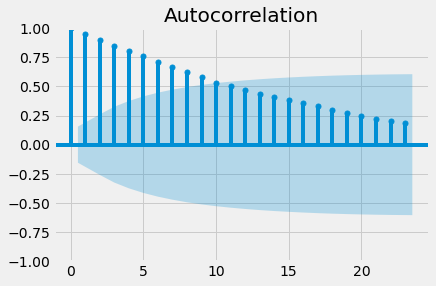

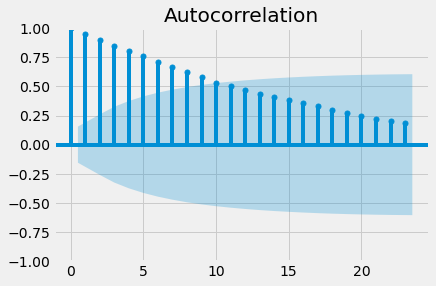

In [55]:
plot_acf(df)

In [56]:
## q=0 p=1 d= 0-1 

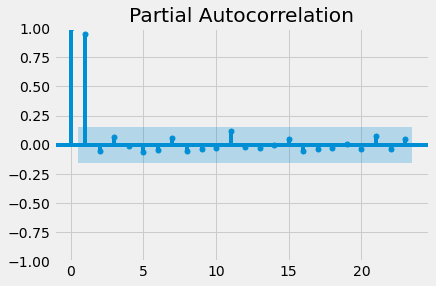

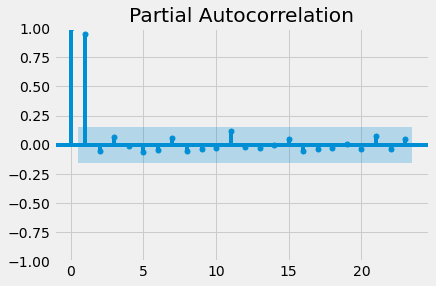

In [57]:
plot_pacf(df)

In [58]:
from statsmodels.tsa.arima_model import ARIMA ## Autoregressive(p) Integrated(d) Moving Average(q)

In [59]:
print(df.shape)
train=df.iloc[:-60]
test=df.iloc[-60:]
print(train.shape,test.shape)

(160, 1)
(100, 1) (60, 1)


In [60]:
model = sm.tsa.ARIMA(train, order=(0, 1, 0));

C:\Users\Omprakash vootla\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Omprakash vootla\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Omprakash vootla\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [61]:
model_fit = model.fit()

In [62]:
model_fit.aic ## information criteria

-170.68166105589597

In [63]:
df_forecast = model_fit.forecast(steps=60);

In [64]:
df_forecast

1994-01-01    6.423247
1994-04-01    6.423247
1994-07-01    6.423247
1994-10-01    6.423247
1995-01-01    6.423247
1995-04-01    6.423247
1995-07-01    6.423247
1995-10-01    6.423247
1996-01-01    6.423247
1996-04-01    6.423247
1996-07-01    6.423247
1996-10-01    6.423247
1997-01-01    6.423247
1997-04-01    6.423247
1997-07-01    6.423247
1997-10-01    6.423247
1998-01-01    6.423247
1998-04-01    6.423247
1998-07-01    6.423247
1998-10-01    6.423247
1999-01-01    6.423247
1999-04-01    6.423247
1999-07-01    6.423247
1999-10-01    6.423247
2000-01-01    6.423247
2000-04-01    6.423247
2000-07-01    6.423247
2000-10-01    6.423247
2001-01-01    6.423247
2001-04-01    6.423247
2001-07-01    6.423247
2001-10-01    6.423247
2002-01-01    6.423247
2002-04-01    6.423247
2002-07-01    6.423247
2002-10-01    6.423247
2003-01-01    6.423247
2003-04-01    6.423247
2003-07-01    6.423247
2003-10-01    6.423247
2004-01-01    6.423247
2004-04-01    6.423247
2004-07-01    6.423247
2004-10-01 

In [65]:
test

,Clerical_employees_female
date,
1994-01-01,6.475433
1994-04-01,6.461468
1994-07-01,6.398595
1994-10-01,6.423247
1995-01-01,6.536692
1995-04-01,6.469250
1995-07-01,6.507278
1995-10-01,6.499787
1996-01-01,6.536692


In [66]:
np.sqrt(mean_squared_error(test, df_forecast))

0.48000040390481313

In [67]:
## base line model np.sqrt(df_error)= 67.2888264388822 and ARIMA model np.sqrt(mean_squared_error(df_test, df_forecast))= 1.799866173753051
## means base line model is better than ARIMA model

In [68]:
## we can conclude that base model is fits well for the data. up to here ## https://www.youtube.com/watch?v=1KGcmLP65uo

In [69]:
## Below is method two

In [70]:
from statsmodels.tsa.arima_model import ARIMA

In [71]:
print(df.shape)
train=df.iloc[:-60]
test=df.iloc[-60:]
print(train.shape,test.shape)

(160, 1)
(100, 1) (60, 1)


In [72]:
model=sm.tsa.ARIMA(train['Clerical_employees_female'],order=(0,1,0))
model=model.fit()
model.summary()

C:\Users\Omprakash vootla\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Omprakash vootla\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Omprakash vootla\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:     Clerical_employees_female   No. Observations:                  100
Model:                        ARIMA(0, 1, 0)   Log Likelihood                  86.341
Date:                       Thu, 25 May 2023   AIC                           -170.682
Time:                               15:48:03   BIC                           -168.087
Sample:                           01-01-1969   HQIC                          -169.632
                                - 10-01-1993                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0102      0.000     31.710      0.000       0.010       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6394.98
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             5.07
Prob(H) (two-sided):                  0.23   Kurtosis:                        41.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

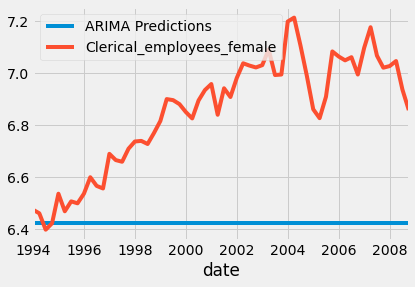

In [73]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
#print(pred)
pred.plot(legend=True)
test['Clerical_employees_female'].plot(legend=True);

In [74]:
df["Clerical_employees_female"].mean()

6.577561706998938

In [75]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['Clerical_employees_female'].mean()
rmse=sqrt(mean_squared_error(pred,test['Clerical_employees_female']))
print(rmse)

0.48000040390481313


In [76]:
model2 = sm.tsa.ARIMA(df['Clerical_employees_female'], order=(0,1,0))
model2=model2.fit();
#df.tail();

C:\Users\Omprakash vootla\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Omprakash vootla\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Omprakash vootla\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [77]:
pred=model2.predict(start=len(df), end=len(df)+60, type='levels').rename('ARIMA predictions')
print(pred)

2009-01-01    6.857514
2009-04-01    6.857514
2009-07-01    6.857514
2009-10-01    6.857514
2010-01-01    6.857514
                ...   
2023-01-01    6.857514
2023-04-01    6.857514
2023-07-01    6.857514
2023-10-01    6.857514
2024-01-01    6.857514
Freq: QS-OCT, Name: ARIMA predictions, Length: 61, dtype: float64


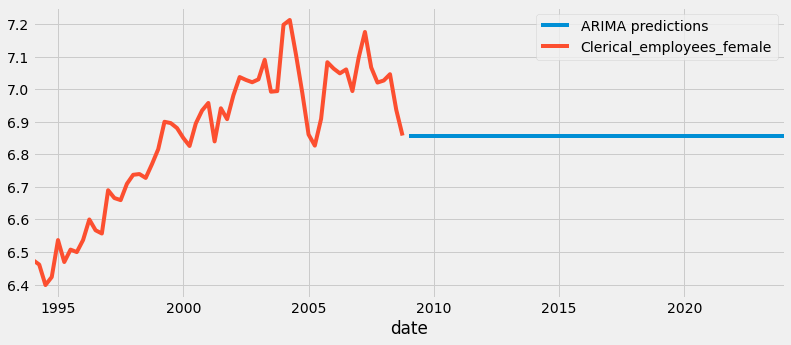

In [78]:
pred.plot(figsize=(12,5),legend=True)
test['Clerical_employees_female'].plot(legend=True);

In [ ]:
## https://medium.com/swlh/temperature-forecasting-with-arima-model-in-python-427b2d3bcb53

## https://www.youtube.com/watch?v=8FCDpFhd1zk

## https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt

## https://www.youtube.com/watch?v=1KGcmLP65uo

## https://www.youtube.com/watch?v=MVsKaYzEggY ***
